In [206]:
from pathlib import Path
import os

import torch
from torch.utils.data import TensorDataset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from FUCCIDataset import FUCCIDatasetInMemory, ReferenceChannelDatasetInMemory, FUCCIChannelDatasetInMemory
from LightningModules import AutoEncoder, FUCCIDataModule
import lightning.pytorch as pl
from lightning.pytorch.callbacks import BasePredictionWriter

In [205]:
scale = 0.5
samples_ct = 10
replicates = 10
save_path = Path("/data/ishang/nb_data/")
data_path = Path("/data/ishang/Fucci-dataset-v3_filtered/")
model_path = Path("/data/ishang/fucci_vae/FUCCI_reference_VAE_2023_06_06_22_45/lightning_logs/461-3518881.75.ckpt")
channel = "reference"
assert channel in str(model_path)
if not data_path.exists():
    os.mkdir(data_path)

In [184]:
model = AutoEncoder.load_from_checkpoint(model_path)

In [185]:
mu_file = data_path / (channel + "_mu.pt")
var_file = data_path / (channel + "_var.pt")
indices_file = data_path / (channel + "_indices.npy")
colors_file = data_path / "colors.npy"

In [186]:
mu = torch.load(mu_file)
var = torch.load(var_file)
indices = np.load(indices_file)
colors = np.load(colors_file)

In [187]:
print(mu.min(), mu.mean(), mu.max())
print(torch.pow(mu.var(), 0.5))

tensor(-187.0561) tensor(-0.2738) tensor(166.7893)
tensor(10.8707)


In [188]:
dataset = ReferenceChannelDatasetInMemory(data_path, imsize=256)

In [189]:
# plot the mean and standard deviation of each channel in the latent space
d = 4
q = torch.Tensor([1 / d * i for i in range(d + 1)])
mu_q = torch.quantile(mu, q, dim=0)
print(mu_q.shape)
print(mu_q[:10, :10])


torch.Size([5, 512])
tensor([[-77.3328, -53.9031, -74.6104, -74.9026, -68.5143, -54.1944, -64.6627,
         -71.4505, -58.3654, -61.2098],
        [ -6.8504,  -0.5230,  -5.7771,  -0.8761,  -9.2498,  -8.6387,   0.8525,
          -8.8693,  -4.2389,  -4.0707],
        [ -1.1339,   4.6498,   1.1788,   6.8319,  -2.1670,  -2.5924,   8.0851,
          -2.6249,   1.5848,   1.2465],
        [  4.0450,  10.4776,   7.1527,  13.2163,   3.7748,   3.0265,  13.6229,
           2.6809,   6.5683,   6.2091],
        [ 50.2640,  62.5937,  59.2689,  66.8233,  61.5443,  64.6337,  49.3590,
          46.2496,  51.5542,  55.8145]])


<Axes: >

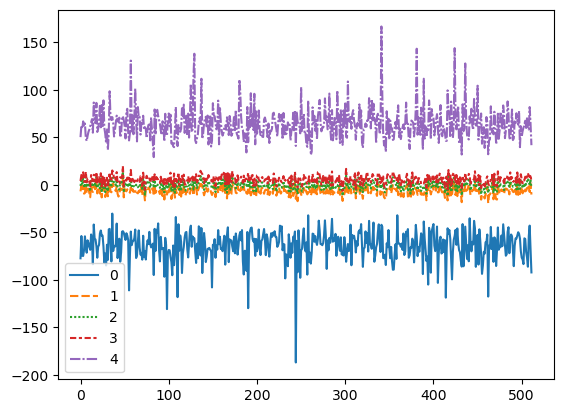

In [190]:
sns.lineplot(data=mu_q.T.numpy())

tensor(308.4889) tensor(84.6833)


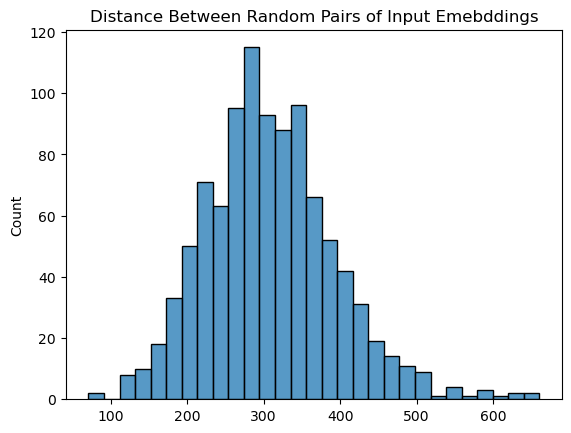

In [217]:
sample_indices = np.random.choice(len(dataset), 1000, replace=False)
sample_mu = mu[sample_indices]
partner_indices = np.random.choice(len(dataset), 1000, replace=False)
partner_mu = mu[partner_indices]
distance = torch.linalg.vector_norm(sample_mu[:, :] - partner_mu[:, :], dim=1)
print(distance.mean(), distance.std())
sns.histplot(distance)
plt.title("Distance Between Random Pairs of Input Emebddings")
plt.show()

In [191]:
sample_indices = np.random.choice(len(dataset), samples_ct, replace=False)
sample_mu = mu[sample_indices]
emp_std = sample_mu.std(dim=0) / scale

print(sample_mu.shape)

eps_shape = [sample_mu.shape[0], replicates, sample_mu.shape[1]] # 5 samples per example data point
# for d in sample_mu.shape:
#     eps_shape.append(d)

eps = torch.randn(eps_shape)
print(eps.shape, emp_std.shape, sample_mu.shape)
samples = eps[:, :, :] * emp_std[None, None, :] + sample_mu[:, None, :]

torch.Size([100, 512])
torch.Size([100, 5, 512]) torch.Size([512]) torch.Size([100, 512])


In [192]:
print(samples.shape, emp_std.shape, sample_mu.shape)

torch.Size([100, 5, 512]) torch.Size([512]) torch.Size([100, 512])


In [193]:
sample_diff = (samples[:, :, :] - sample_mu[:, None, :]).squeeze()
sample_diff = torch.linalg.vector_norm(sample_diff, dim=2)
print(sample_diff.shape)
print(torch.mean(sample_diff, dim=1)[:5])
print(torch.std(sample_diff, dim=1)[:5])

torch.Size([100, 5])
tensor([455.7994, 451.7717, 464.7516, 454.6866, 452.6715])
tensor([10.9602, 13.0998, 14.2256, 17.1147, 15.3901])


In [194]:
samples = samples.reshape(-1, samples.shape[-1])
# samples = torch.stack([samples, samples], dim=1)
# samples[:, 1, :] = 0

In [195]:
class CustomWriter(BasePredictionWriter):

    def __init__(self, output_dir, write_interval):
        super().__init__(write_interval)
        self.output_dir = output_dir

    def write_on_epoch_end(self, trainer, pl_module, predictions, batch_indices):
        # this will create N (num processes) files in `output_dir` each containing
        # the predictions of it's respective rank
        torch.save(predictions, os.path.join(self.output_dir, f"predictions_{trainer.global_rank}.pt"))

        # optionally, you can also save `batch_indices` to get the information about the data index
        # from your prediction data
        torch.save(batch_indices, os.path.join(self.output_dir, f"batch_indices_{trainer.global_rank}.pt"))


In [196]:
from torch.utils.data import Dataset

class SimpleDataset(Dataset):
    def __init__(self, tensor) -> None:
        self.tensor = tensor

    def __getitem__(self, index):
        return self.tensor[index]

    def __len__(self):
        return self.tensor.size(0)

In [197]:
predictions_dir = save_path / "sample_predictions"
if not predictions_dir.exists():
    os.mkdir(predictions_dir)
for f in predictions_dir.glob("*"):
    f.unlink()
pred_writer = CustomWriter(output_dir=predictions_dir, write_interval="epoch")

sample_dm = pl.LightningDataModule.from_datasets(predict_dataset=SimpleDataset(samples), batch_size=5, num_workers=1)
print(samples.shape)
print(len(SimpleDataset(samples)))
print(len(sample_dm.predict_dataloader()))

model.set_predict_mode("sampling")

trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[pred_writer])
trainer.predict(model, datamodule=sample_dm, return_predictions=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


torch.Size([500, 512])
500
100


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [198]:
!ls /data/ishang/nb_data/sample_predictions/

batch_indices_0.pt  predictions_0.pt


In [199]:
batch_indices = torch.load(predictions_dir / "batch_indices_0.pt")[0]
predictions = torch.load(predictions_dir / "predictions_0.pt")
print(len(batch_indices), len(predictions))
print(len(batch_indices), predictions[0].shape)
predictions = torch.stack(predictions, dim=0)

100 100
100 torch.Size([5, 2, 256, 256])


In [200]:
indices = [i for batch in batch_indices for i in batch]
for i in range(len(indices)):
    assert indices[i] == i

torch.Size([100, 5]) torch.Size([100, 5])


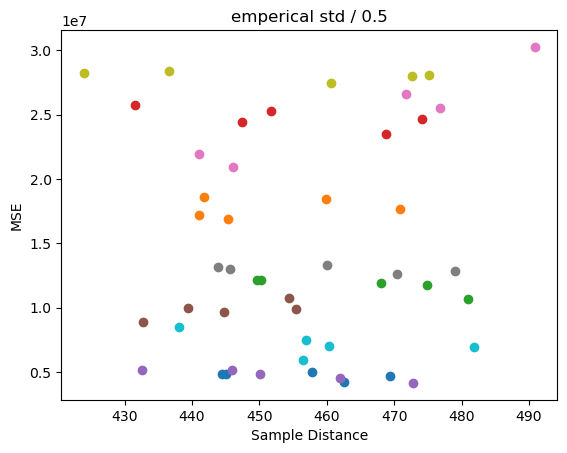

In [201]:
targets = dataset[sample_indices]
mse = torch.pow(predictions[:, :, :, :] - targets[:, None, :, :], 2).mean(dim=(2, 3, 4))
print(sample_diff.shape, mse.shape)

import matplotlib.pyplot as plt

for i in range(10):
    plt.scatter(sample_diff[i], mse[i])
plt.xlabel("Sample Distance")
plt.ylabel("MSE")
plt.title(f"emperical std / {scale}")
plt.show()

Text(0.5, 1.0, 'Distance Between Input Embeddings and Centroid')

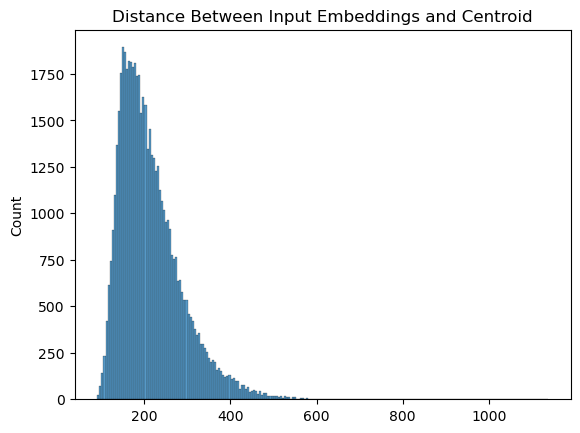

In [203]:
centroid = torch.mean(mu, dim=0)
distances = torch.linalg.vector_norm(mu[:, :] - centroid[None, :], dim=1)
sns.histplot(distances)
plt.title("Distance Between Input Embeddings and Centroid")

Text(0.5, 1.0, 'Quantiles of Distance Between Input Embeddings and Centroid')

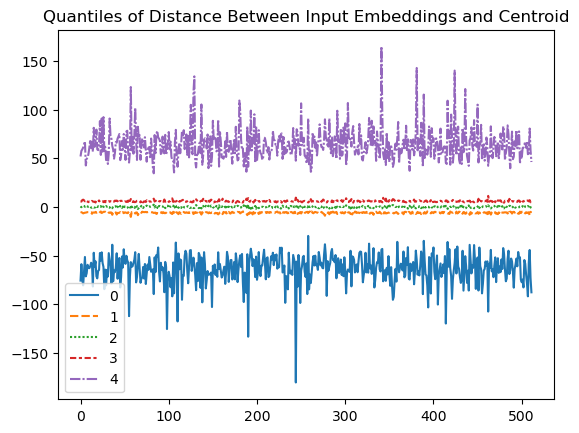

In [204]:
centroid = torch.mean(mu, dim=0)
distances = mu[:, :] - centroid[None, :]
dimension_quantiles = torch.quantile(distances, q, dim=0)
sns.lineplot(data=dimension_quantiles.T.numpy())
plt.title("Quantiles of Distance Between Input Embeddings and Centroid")